In [2]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Download all builder configs for multiple ColliderML datasets
from datasets import load_dataset, DownloadConfig
import os
n_rows = 1000  # number of rows to download per config
custom_cache_path = "/storage/agrp/barakma/h_faces_cache"
os.environ["HF_DATASETS_CACHE"] = custom_cache_path           # datasets cache
os.environ["HF_HUB_CACHE"] = os.path.join(custom_cache_path, "hub")  # hub cache (used by streaming and scripts)
# List the dataset names you want to pull
colliderml_datasets = [
    "OpenDataDetector/ColliderML_ttbar_pu0",
    #"OpenDataDetector/ColliderML_higgs_pu0",
]
# Known configs exposed by the builder (from the error message)
builder_configs = ["particles", "tracker_hits", "calo_hits", "tracks"]
dl_cfg = DownloadConfig(
    cache_dir=custom_cache_path,
    local_files_only=True,   # do not hit the network; fail if not cached
    resume_download=True,
)
all_datasets = {}
for ds_name in colliderml_datasets:
    print(f"\n=== Dataset: {ds_name} ===")
    all_datasets[ds_name] = {}
    for cfg in builder_configs:
        print(f"Downloading config: {cfg}")
        # Each call returns a DatasetDict with train (and possibly other splits)
        all_datasets[ds_name][cfg] = load_dataset(
            ds_name,
            cfg,
            cache_dir=custom_cache_path,
            download_config=dl_cfg,
            split={"train": f"train[:{n_rows}]"},

        )
        # Basic info summary
        splits = list(all_datasets[ds_name][cfg].keys())
        print(f"  -> got splits: {splits}")
        for split in splits[:1]:  # just first split for brevity
            print(
                f"     {cfg}/{split}: {len(all_datasets[ds_name][cfg][split])} rows"
            )

print("\nCompleted downloads. Access structure like: all_datasets['OpenDataDetector/ColliderML_ttbar_pu0']['particles']['train'][:5]")

/storage/agrp/barakma/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=== Dataset: OpenDataDetector/ColliderML_ttbar_pu0 ===
  -> got splits: ['train']
     particles/train: 1000 rows
  -> got splits: ['train']
     tracker_hits/train: 1000 rows
  -> got splits: ['train']
     calo_hits/train: 1000 rows
  -> got splits: ['train']
     tracks/train: 1000 rows

Completed downloads. Access structure like: all_datasets['OpenDataDetector/ColliderML_ttbar_pu0']['particles']['train'][:5]


In [101]:
all_datasets
# pickle it and save, first gzip it 
import pickle
import gzip
with gzip.open('all_datasets.pkl.gz', 'wb') as f:
    pickle.dump(all_datasets, f)

 

In [5]:
# read it back
import pickle
import gzip
with gzip.open('all_datasets.pkl.gz', 'rb') as f:
    all_datasets_loaded = pickle.load(f)   

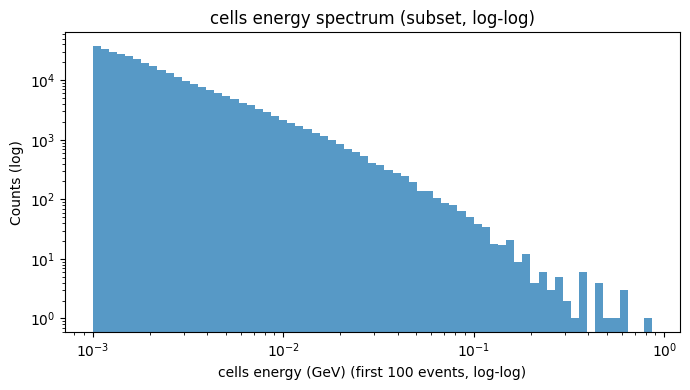

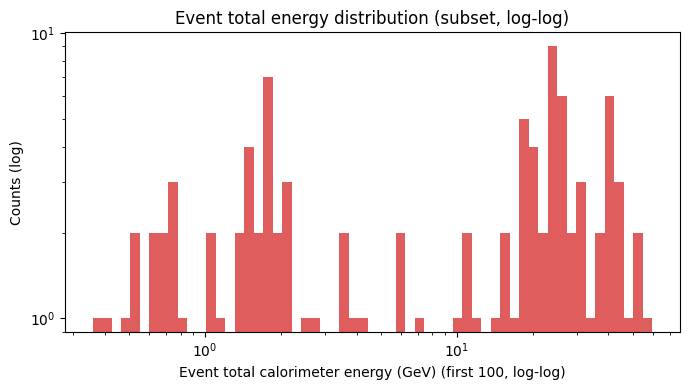

In [7]:
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt
dataset = all_datasets_loaded['OpenDataDetector/ColliderML_ttbar_pu0']
calo_e = dataset['calo_hits']['train'].with_format('numpy')
N_events = 100
total_energy_events = calo_e['total_energy'][:N_events]

# Cluster energies (subset)
all_E_N = np.concatenate([np.asarray(e, dtype=float) for e in total_energy_events])
all_E_N = all_E_N[all_E_N > 0]

# Log-spaced bins for x (energy)
bins_E = np.geomspace(max(all_E_N.min(), 1e-3), all_E_N.max(), 70)

plt.figure(figsize=(7,4))
plt.hist(all_E_N, bins=bins_E, color="#1f77b4", alpha=0.75)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(f"cells energy (GeV) (first {N_events} events, log-log)")
plt.ylabel("Counts (log)")
plt.title("cells energy spectrum (subset, log-log)")
plt.tight_layout()
plt.show()

# Per-event total energy (subset)
event_sum_E_N = np.array([np.sum(np.asarray(e, dtype=float)) for e in total_energy_events])
event_sum_E_N = event_sum_E_N[event_sum_E_N > 0]

bins_evt = np.geomspace(max(event_sum_E_N.min(), 1e-3), event_sum_E_N.max(), 60)

plt.figure(figsize=(7,4))
plt.hist(event_sum_E_N, bins=bins_evt, color="#d62728", alpha=0.75)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(f"Event total calorimeter energy (GeV) (first {N_events}, log-log)")
plt.ylabel("Counts (log)")
plt.title("Event total energy distribution (subset, log-log)")
plt.tight_layout()
plt.show()
# ...existing code...

1000


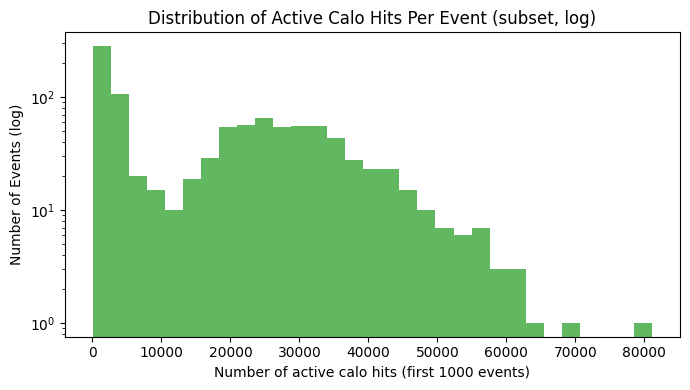

In [28]:
N_events = 1000
dataset = all_datasets_loaded['OpenDataDetector/ColliderML_ttbar_pu0']
# The .with_format('numpy') part is specific to Hugging Face Datasets.
# The logic works the same if `calo_e` is a dictionary of lists/arrays.
calo_e = dataset['calo_hits']['train']
print(len(calo_e))
total_energy_events = calo_e['total_energy'][:N_events]

# (Your existing plots for energy spectrum and total energy would be here)
# ...
# ...


# --- New Code Block: Histogram of the number of calo hits per event ---

# Number of calo hits per event (subset)
# For each event, the number of hits is simply the length of its energy list.
event_hit_counts = np.array([len(e) for e in total_energy_events])

# Calculate the number of bins for the histogram
num_bins = int(np.sqrt(N_events))

plt.figure(figsize=(7,4))
# Plot the histogram using the calculated hit counts
plt.hist(event_hit_counts, bins=num_bins, color="#2ca02c", alpha=0.75) # Using a different color
plt.yscale("log") # Use a log scale for the y-axis to better see the distribution
plt.xlabel(f"Number of active calo hits (first {N_events} events)")
plt.ylabel("Number of Events (log)")
plt.title("Distribution of Active Calo Hits Per Event (subset, log)")
plt.tight_layout()
plt.show()

41754

In [9]:
from cluster.plot import plot_energy_ratio_vs_cutoff
plot_energy_ratio_vs_cutoff(all_datasets_loaded, dataset_name="OpenDataDetector/ColliderML_ttbar_pu0", N_events=100)

In [11]:
import importlib, inspect
import cluster.play as play
from cluster.helpers.meanshift_mod import  MeanShiftMod
all_datasets = all_datasets_loaded 
m = MeanShiftMod(bin_seeding=True, bandwidth=0.6)
# Ensure latest code is loaded (even if previously imported)
play = importlib.reload(play)
from cluster.play import get_points_for_clustering
points= get_points_for_clustering(all_datasets, until_index=7,energy_threshold=0.00005)[1]


In [12]:
m.fit(points['points'])

MeanShiftMod(bandwidth=0.6, bin_seeding=True)

Processing particle completeness for 1 events...
Calculation complete. Found 2214 particles in total.


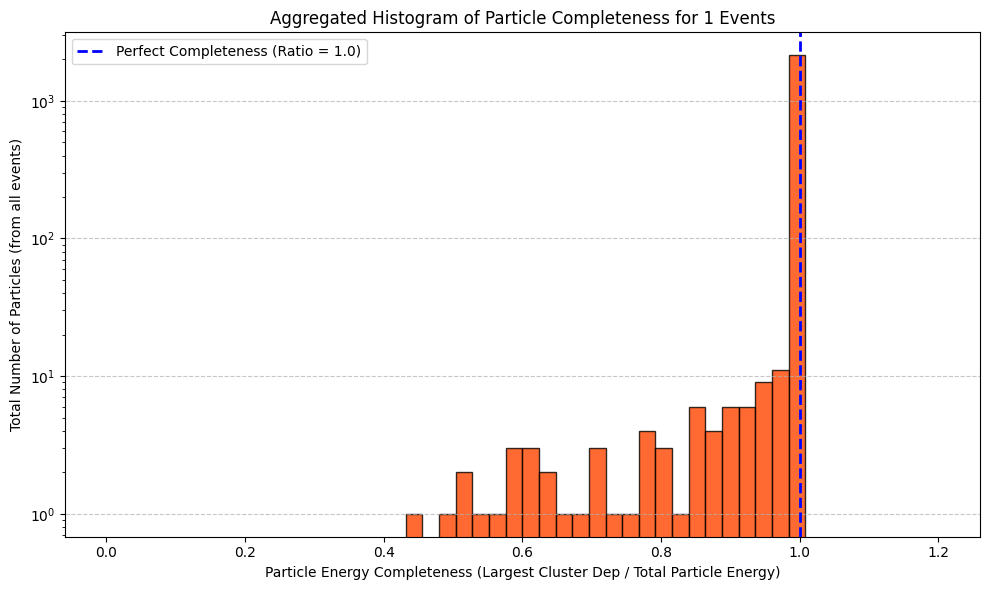

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9391499505241231,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.993294615373575,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9422000343573362,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.775822161850532,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9360588239517627,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.

In [17]:
from cluster.plot import plot_cluster_energy_purity_interactive,plot_aggregated_cluster_purity,plot_aggregated_particle_completeness

event_data = all_datasets_loaded['OpenDataDetector/ColliderML_ttbar_pu0']['calo_hits']['train'][1]  # first event
mask = points['mask_calo']
plot_aggregated_particle_completeness(ms_models=[m], full_dataset=all_datasets_loaded['OpenDataDetector/ColliderML_ttbar_pu0']['calo_hits']['train'], event_indices=[1], mask_list=[mask])

In [ ]:
import importlib, inspect
import cluster.play as play
from cluster.helpers.meanshift_mod import  MeanShiftMod
all_datasets = all_datasets_loaded 
N = 40
m_list = [MeanShiftMod(bin_seeding=True, bandwidth=0.7) for _ in range(N)]

# Ensure latest code is loaded (even if previously imported)
play = importlib.reload(play)
from cluster.play import get_points_for_clustering
points_list= get_points_for_clustering(all_datasets, until_index=N,energy_threshold=0.000005)
from cluster.play import parrallel_fit
m_n_list = parrallel_fit(m_list, points_list)


[Parallel] START fit 1/20 | points shape=(15906, 2)[Parallel] START fit 2/20 | points shape=(21631, 2)
[Parallel] START fit 3/20 | points shape=(2195, 2)
[Parallel] START fit 4/20 | points shape=(709, 2)
[Parallel] START fit 5/20 | points shape=(32460, 2)
[Parallel] START fit 6/20 | points shape=(33428, 2)
[Parallel] START fit 7/20 | points shape=(41809, 2)
[Parallel] START fit 8/20 | points shape=(29144, 2)
[Parallel] START fit 9/20 | points shape=(34247, 2)
[Parallel] START fit 10/20 | points shape=(2148, 2)
[Parallel] START fit 11/20 | points shape=(2623, 2)
[Parallel] START fit 12/20 | points shape=(43069, 2)
[Parallel] START fit 13/20 | points shape=(41241, 2)
[Parallel] START fit 14/20 | points shape=(21378, 2)
[Parallel] START fit 15/20 | points shape=(28981, 2)
[Parallel] START fit 16/20 | points shape=(1863, 2)
[Parallel] START fit 17/20 | points shape=(49413, 2)
[Parallel] START fit 18/20 | points shape=(6215, 2)
[Parallel] START fit 19/20 | points shape=(23987, 2)
[Parallel]

In [39]:
m_n_list[6].labels_

array([6, 6, 6, ..., 5, 5, 5], shape=(41809,))

Processing 20 events...
Calculation complete. Found 327 clusters in total.


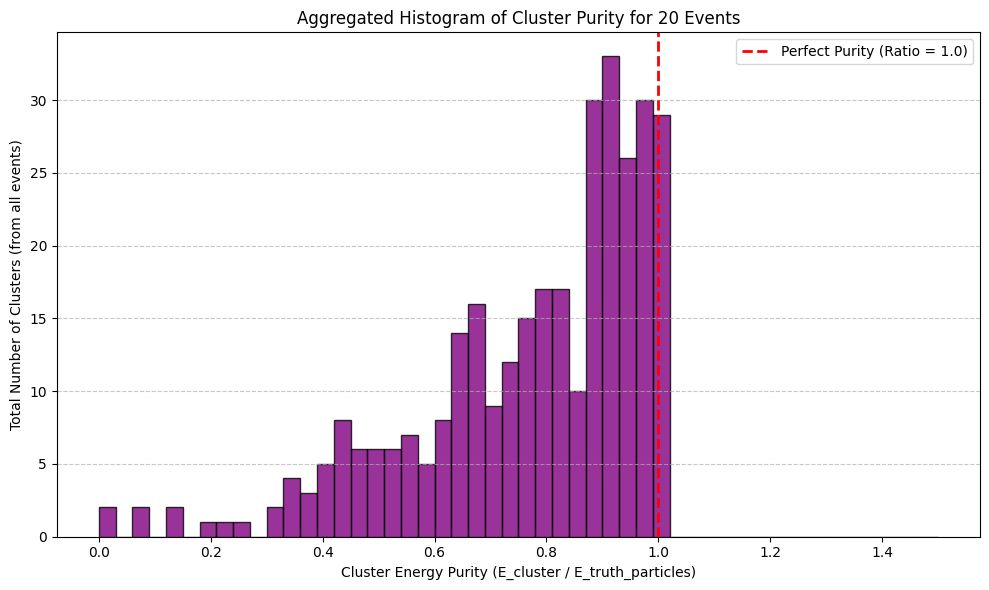

[0.9889750577316255,
 0.9908949200817107,
 0.8391377576728826,
 0.9925576445106988,
 0.9623446383957408,
 0.9980204203023167,
 1.000000001471324,
 0.018262316247186054,
 0.9969388272237372,
 0.024815876681649182,
 0.8220170009212113,
 0.9249934757308703,
 0.3813950409697894,
 0.24085576726539656,
 0.9081945058992761,
 0.1449586724308055,
 0.9218606127081553,
 0.992824726495743,
 1.0,
 0.7577755577523064,
 0.96087435057977,
 0.9695344551255377,
 0.9874595809872528,
 0.9716805724485702,
 0.928771205182188,
 0.9054222113701251,
 1.0,
 0.627303465622573,
 0.4087465934776055,
 0.9933787927379423,
 0.6896351076668081,
 0.919537492920609,
 0.653220179904485,
 0.5354315313822402,
 0.3711572456954312,
 0.9112760306515449,
 0.8865298923714754,
 1.0000000015997115,
 0.657589709749701,
 0.9064268581207723,
 0.3315615264186312,
 0.8960964423060868,
 0.9694522382447935,
 0.7755926222179934,
 0.9307997689086798,
 0.8736680010026802,
 0.7909891388175803,
 0.8807760255038616,
 0.6361356757980258,
 0.74

In [45]:
plot_aggregated_cluster_purity(ms_models=m_n_list, full_dataset=all_datasets_loaded['OpenDataDetector/ColliderML_ttbar_pu0']['calo_hits']['train'], event_indices=range(N), mask_list=[i['mask_calo'] for i in points_list])

Processing particle completeness for 20 events...
Calculation complete. Found 60854 particles in total.


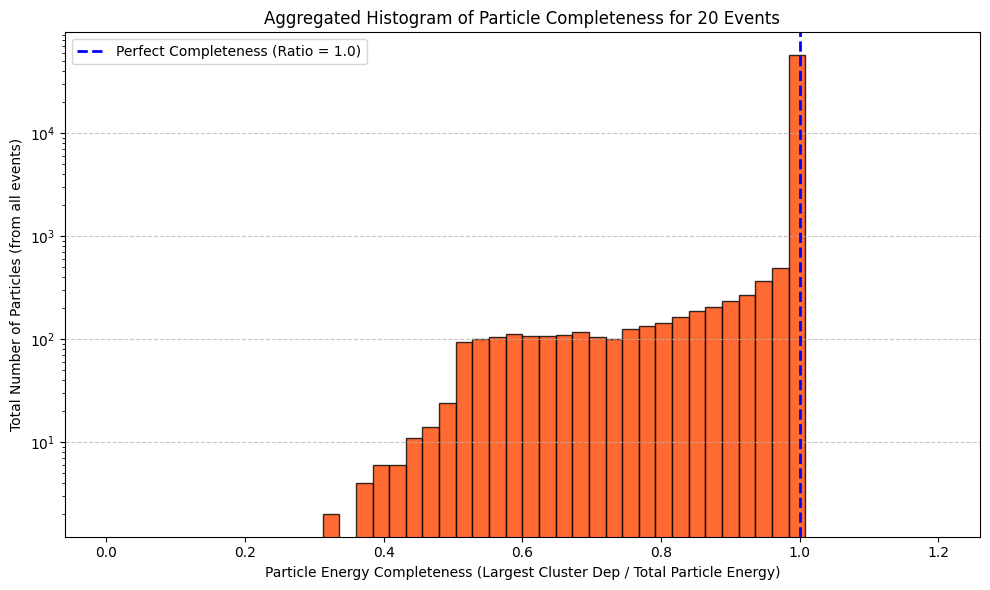

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9911824539541263,
 0.7526417262862105,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [46]:
plot_aggregated_particle_completeness(ms_models=m_n_list, full_dataset=all_datasets_loaded['OpenDataDetector/ColliderML_ttbar_pu0']['calo_hits']['train'], event_indices=range(N), mask_list=[i['mask_calo'] for i in points_list])

In [82]:
m.labels_

array([ 1,  1,  1, ...,  2,  2, 19])

In [21]:
from cluster.plot import plot_calo_clusters_3d, plot_calo_clusters_3d_given
from cluster.play import get_points_for_clustering
import cluster.plot as cplot
import importlib
all_datasets = all_datasets_loaded
importlib.reload(cplot)
dataset_name="OpenDataDetector/ColliderML_ttbar_pu0"
event_idx=0
bandwidth=0.6
energy_threshold=0.00005
calo = all_datasets[dataset_name]["calo_hits"]["train"].with_format("numpy")
points_list = get_points_for_clustering(all_datasets, dataset_name=dataset_name, energy_threshold=energy_threshold, until_index=event_idx+1)
data = points_list[event_idx]['points']



In [40]:
data.shape

(17371, 2)

In [ ]:
m_n_list[event_idx].labels_

n_clusters: 19
centers shape: (19, 2)
cluster counts (in masked view): {np.int64(1): np.int64(3), np.int64(2): np.int64(7), np.int64(3): np.int64(1), np.int64(4): np.int64(1), np.int64(9): np.int64(1), np.int64(15): np.int64(2), np.int64(17): np.int64(1)}
   eta_center  phi_center  cluster_id  count
0   -0.344619    2.060427           1      3
1   -0.218892    0.396031           2      7
2   -0.847122    1.205459           3      1
3   -1.099178   -1.783306           4      1
4    1.633961    1.453048           9      1


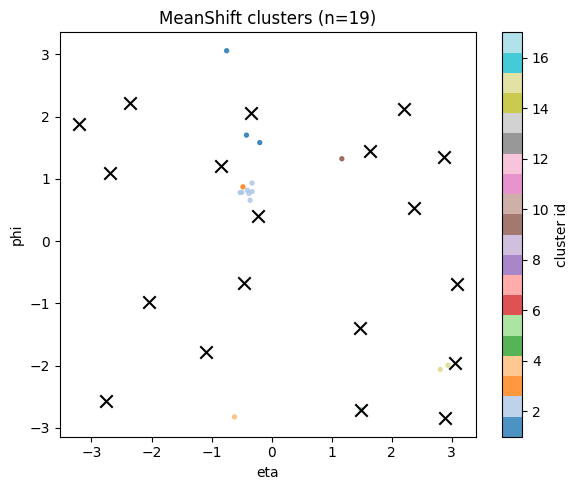

n_clusters: 19
centers shape: (19, 2)
cluster counts (in masked view): {np.int64(0): np.int64(4037), np.int64(1): np.int64(3352), np.int64(2): np.int64(2523), np.int64(3): np.int64(2359), np.int64(4): np.int64(2052), np.int64(5): np.int64(636), np.int64(6): np.int64(183), np.int64(7): np.int64(246), np.int64(8): np.int64(197), np.int64(9): np.int64(75), np.int64(10): np.int64(100), np.int64(11): np.int64(44), np.int64(12): np.int64(29), np.int64(13): np.int64(42), np.int64(14): np.int64(6), np.int64(15): np.int64(2), np.int64(16): np.int64(5), np.int64(17): np.int64(1), np.int64(18): np.int64(1)}
   eta_center  phi_center  cluster_id  count
0   -2.035195   -0.982429           0   4037
1   -0.344619    2.060427           1   3352
2   -0.218892    0.396031           2   2523
3   -0.847122    1.205459           3   2359
4   -1.099178   -1.783306           4   2052


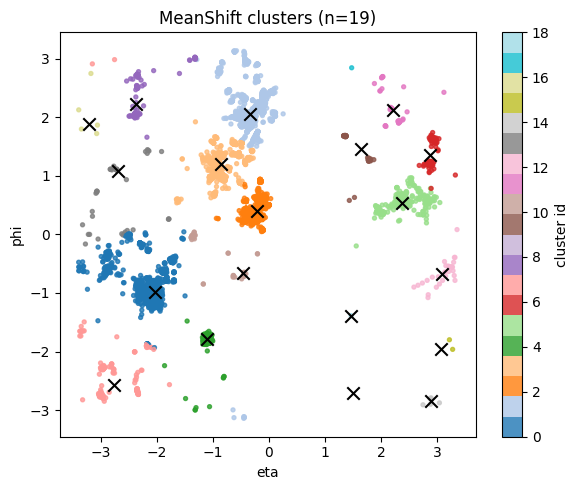

Number of tracks cells in mask: 16


In [35]:
from cluster.plot import plot_2d_meanshift_results
points = points_list[0]['points']
calo_mask = points_list[0]['mask_calo']
m = m_n_list[0]
plot_2d_meanshift_results(points, m, mask=~calo_mask)
plot_2d_meanshift_results(points, m, mask=calo_mask)

# count number of truth in mask
print("Number of tracks cells in mask:", np.sum(~calo_mask))

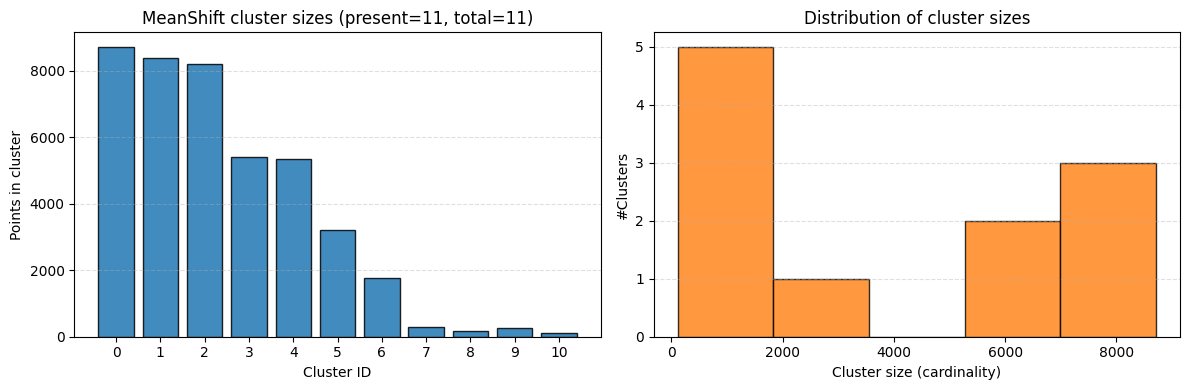

cluster_id  count
0            0   8712
1            1   8384
2            2   8188
3            3   5399
4            4   5330
5            5   3196
6            6   1765
7            7    292
8            8    158
9            9    268
10          10    117

In [40]:
from cluster.plot import plot_cluster_cardinality_histogram
plot_cluster_cardinality_histogram(m_n_list[6])

In [49]:
import importlib
import cluster.plot
importlib.reload(cluster.plot)
from cluster.plot import plot_calo_clusters_3d, plot_calo_clusters_3d_given
event_idx=0

m = m_n_list[event_idx]
dataset_name="OpenDataDetector/ColliderML_ttbar_pu0"
plot_calo_clusters_3d_given(event_idx, points_list, m, all_datasets_loaded, dataset_name=dataset_name, show=True)

(array([ 1,  1,  1, ..., 16,  7, 16], shape=(15890,)),
 array([[-2.0520947 , -1.0109853 ],
        [-0.34695083,  2.058361  ],
        [-0.21795726,  0.3953685 ],
        [-0.85220367,  1.2028143 ],
        [-1.099178  , -1.7833062 ],
        [ 2.3652558 ,  0.5394118 ],
        [ 2.8946059 ,  1.4161837 ],
        [-2.7731135 , -2.5799484 ],
        [-2.3650947 ,  2.2222028 ],
        [-1.4557383 ,  0.17727092],
        [-2.1986375 , -1.9351501 ],
        [ 1.6100706 ,  1.4316397 ],
        [-0.46659502, -0.66556627],
        [ 2.2030823 ,  2.127181  ],
        [ 3.0875962 , -0.6838614 ],
        [-2.5899606 ,  1.1795081 ],
        [-3.3124325 , -1.6309329 ],
        [ 2.8829668 , -2.8479044 ],
        [ 3.0574186 , -1.9550283 ],
        [-3.212737  ,  1.8787105 ],
        [ 3.1164312 ,  2.4270835 ],
        [ 1.4898881 , -2.707087  ],
        [ 1.4633487 , -1.3882822 ]], dtype=float32))

In [30]:
calo_e = dataset['calo_hits']['train'].with_format('numpy')

In [38]:
type(calo_e['total_energy']), type(calo_e['contrib_energies'])

(datasets.arrow_dataset.Column, datasets.arrow_dataset.Column)


Calculating per-cell energy differences for a single event...
Event 3: 663 cells
Diff stats -> min: 0.000e+00, max: 1.455e-11, mean: 2.195e-14


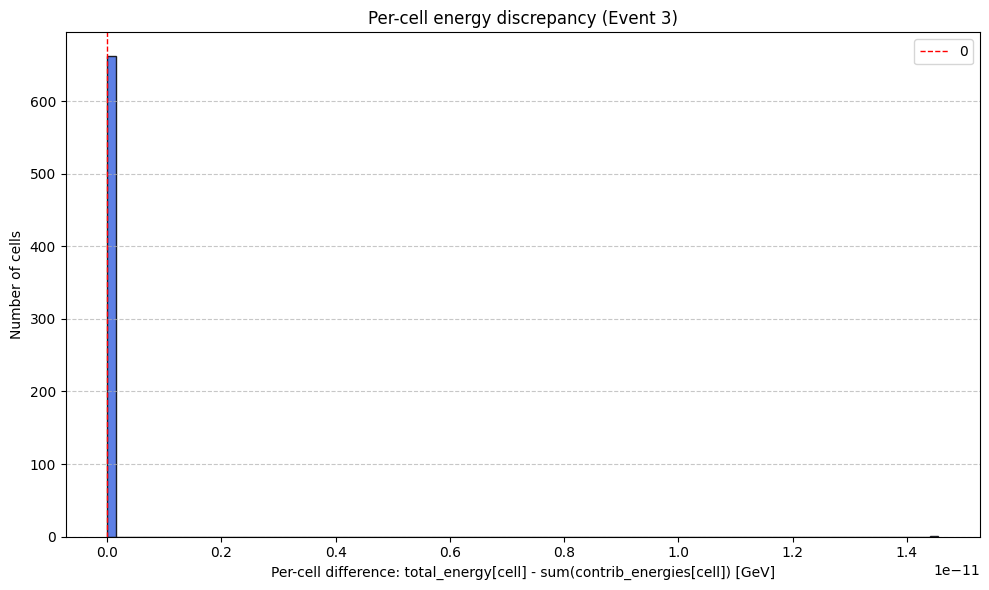

In [43]:
# ...existing code...
print("\nCalculating per-cell energy differences for a single event...")

event_idx = 3  # choose the event to inspect

# Fetch arrays for the chosen event
tot_e = np.asarray(calo_e['total_energy'][event_idx], dtype=np.float64)         # shape: (n_cells,)
contribs_obj = calo_e['contrib_energies'][event_idx]                             # shape: (n_cells,) dtype=object

# Sum contributions per cell (each entry is a 1D array of floats)
contrib_sum_per_cell = np.fromiter(
    (float(np.asarray(a, dtype=np.float64).sum()) if a is not None else 0.0 for a in contribs_obj),
    dtype=np.float64,
    count=len(contribs_obj)
)

# Per-cell difference: total cell energy minus sum of contributions for that cell
cell_diffs = tot_e - contrib_sum_per_cell

print(f"Event {event_idx}: {len(cell_diffs)} cells")
print(f"Diff stats -> min: {cell_diffs.min():.3e}, max: {cell_diffs.max():.3e}, mean: {cell_diffs.mean():.3e}")

# Plot histogram of per-cell differences
plt.figure(figsize=(10, 6))
plt.hist(cell_diffs, bins=100, alpha=0.85, edgecolor='black', color='royalblue')
plt.axvline(0.0, color='red', linestyle='--', linewidth=1, label='0')
plt.xlabel("Per-cell difference: total_energy[cell] - sum(contrib_energies[cell]) [GeV]")
plt.ylabel("Number of cells")
plt.title(f"Per-cell energy discrepancy (Event {event_idx})")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...

In [36]:
from datasets import load_dataset
import json
import numpy as np

# Load the four configurations (replace with full split if needed)
particles = all_datasets["OpenDataDetector/ColliderML_ttbar_pu0"]["particles"]["train"].with_format("numpy")
tracker_hits = all_datasets["OpenDataDetector/ColliderML_ttbar_pu0"]["tracker_hits"]["train"].with_format("numpy")
calo_hits = all_datasets["OpenDataDetector/ColliderML_ttbar_pu0"]["calo_hits"]["train"].with_format("numpy")
tracks = all_datasets["OpenDataDetector/ColliderML_ttbar_pu0"]["tracks"]["train"].with_format("numpy")

phoenix_data = {}

for i in range(1):
    event_id = particles[i]['event_id']
    event_key = f"Event {event_id}"
    event_data = {
        "event number": event_id,
        "run number": 0  # Placeholder; set to actual run if available
    }

    # Hits from tracker_hits
    hits = []
    for j in range(len(tracker_hits[i]['x'])):
        hit = {
            "pos": [tracker_hits[i]['x'][j], tracker_hits[i]['y'][j], tracker_hits[i]['z'][j]],
            "time": tracker_hits[i]['time'][j],
            "particle_id": tracker_hits[i]['particle_id'][j]
        }
        hits.append(hit)
    event_data["Hits"] = {"TrackerHits": hits}

    # Clusters from calo_hits
    clusters = []
    for j in range(len(calo_hits[i]['total_energy'])):
        cluster = {
            "pos": [calo_hits[i]['x'][j], calo_hits[i]['y'][j], calo_hits[i]['z'][j]],
            "e": calo_hits[i]['total_energy'][j]
        }
        clusters.append(cluster)
    event_data["Clusters"] = {"CaloClusters": clusters}

    # Tracks from tracks
    track_list = []
    for j in range(len(tracks[i]['d0'])):
        qop = tracks[i]['qop'][j]
        track = {
            "d0": tracks[i]['d0'][j],
            "z0": tracks[i]['z0'][j],
            "phi": tracks[i]['phi'][j],
            "theta": tracks[i]['theta'][j],
            "qop": qop,
            "charge": 1 if qop > 0 else -1  # Derived from qop sign
        }
        track_list.append(track)
    event_data["Tracks"] = {"ReconstructedTracks": track_list}

    # Vertices from particles (primary only)
    vertices = []
    for j in range(len(particles[i]['vx'])):
        if particles[i]['vertex_primary'][j] > 0:
            vertex = {
                "pos": [particles[i]['vx'][j], particles[i]['vy'][j], particles[i]['vz'][j]]
            }
            vertices.append(vertex)
    if vertices:
        event_data["Vertices"] = {"PrimaryVertices": vertices}

    phoenix_data[event_key] = event_data

# Save to JSON
with open("collider_ml_phoenix.json", "w") as f:
    json.dump(phoenix_data, f, indent=4)

print("JSON file generated: collider_ml_phoenix.json")

KeyboardInterrupt: 